**Exploratory Data Analysis (EDA)**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageOps

In [2]:
# Training on GPU

#device = torch.device('cuda: 0' if torch.cuda.is_available() else 'cpu')
#print(device)

In [3]:
# reproducibility

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

**Dataset Overview**

In [4]:
root_dir = '/content/drive/MyDrive/Intermadiate_Machine_Learning/Final_project/training_set'
benign_dir = f'{root_dir}/benign'
malignant_dir = f'{root_dir}/malignant'
!ls {malignant_dir}

'malignant (100)_mask.png'  'malignant (149).png'	'malignant (52)_mask.png'
'malignant (100).png'	    'malignant (14)_mask.png'	'malignant (52).png'
'malignant (101)_mask.png'  'malignant (14).png'	'malignant (53)_mask_1.png'
'malignant (101).png'	    'malignant (150)_mask.png'	'malignant (53)_mask.png'
'malignant (102)_mask.png'  'malignant (150).png'	'malignant (53).png'
'malignant (102).png'	    'malignant (151)_mask.png'	'malignant (54)_mask.png'
'malignant (103)_mask.png'  'malignant (151).png'	'malignant (54).png'
'malignant (103).png'	    'malignant (152)_mask.png'	'malignant (55)_mask.png'
'malignant (104)_mask.png'  'malignant (152).png'	'malignant (55).png'
'malignant (104).png'	    'malignant (153)_mask.png'	'malignant (56)_mask.png'
'malignant (105)_mask.png'  'malignant (153).png'	'malignant (56).png'
'malignant (105).png'	    'malignant (156)_mask.png'	'malignant (57)_mask.png'
'malignant (106)_mask.png'  'malignant (156).png'	'malignant (57).png'
'malignant (106).png'	  

In [5]:
def create_dataset_info_dataframe(dataset_path):
    data = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}

    # Navigate through each class directory ("benign" and "malignant")
    for label in ['benign', 'malignant']:
        class_dir = os.path.join(dataset_path, label)

        # Dictionary to keep track of the number of masks per study
        study_masks_count = {}

        # Loop through each file in the class directory
        for file in os.listdir(class_dir):
            if file.endswith('.png') and not file.endswith('_mask.png') and not '_mask_' in file:
                # This is a primary study image
                study_id = file.split('.')[0]
                img_path = os.path.join(class_dir, file)
                img = Image.open(img_path)
                x_dim, y_dim = img.size

                # Count masks for this study
                num_of_masks = sum(1 for f in os.listdir(class_dir) if f.startswith(study_id) and ('_mask' in f))

                # Update the dataset
                data['x_dim'].append(x_dim)
                data['y_dim'].append(y_dim)
                data['label'].append(label)
                data['num_of_masks'].append(num_of_masks)
                data['path'].append(img_path)

            elif '_mask' in file:
                # This is a mask, ensure the study is counted for mask numbers
                study_base_id = file.split('_mask')[0]
                study_masks_count[study_base_id] = study_masks_count.get(study_base_id, 0) + 1

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Use the function, replace 'your_dataset_path' with the actual path to your dataset
df = create_dataset_info_dataframe(root_dir)
df.describe()

,x_dim,y_dim,num_of_masks
count,547.000000,547.000000,547.000000
mean,604.976234,492.124314,1.032907
std,120.395249,73.833487,0.188534
min,190.000000,324.000000,1.000000
25%,554.000000,463.000000,1.000000
50%,563.000000,471.000000,1.000000
75%,682.500000,570.000000,1.000000
max,1048.000000,719.000000,3.000000


In [6]:
max_shape = df.y_dim.max(), df.x_dim.max()
max_masks = df.num_of_masks.max()

def pad_image_to_max(img, max_shape=max_shape):
    padding = np.array(max_shape) - np.array(img.shape)
    assert np.all(padding >= 0), (img.shape, max_shape)
    padding = tuple((0,i) for i in padding)
    return np.pad(img, padding, 'constant', constant_values=0)


def norm_mask(mask):
    """Masks are often weird. Check that we have accounted for all edge cases."""
    if len(mask.shape) == 2:
        return mask

    assert len(mask.shape) == 3, mask.shape
    for i in range(1, mask.shape[2]):
        if np.all(mask[...,i] == 255):
            continue
        assert np.all(mask[...,0] == mask[...,i]), i

    return mask[...,0]

def create_mask_tensor(masks, max_masks=max_masks, max_size=max_shape):
    # Initialize a 3D tensor filled with zeros
    tensor = np.zeros((max_masks, *max_size), dtype=np.uint8)
    for i, mask in enumerate(masks[:max_masks]):
        padded_mask = pad_image_to_max(mask, max_size)
        tensor[i] = np.array(padded_mask)

    return tensor

df_block = df.loc[:100].copy()
padded_images = []
mask_tensors = []

for index, row in df_block.iterrows():
    img = np.array(Image.open(row['path']))
    padded_img = pad_image_to_max(img, (*max_shape, 3))
    padded_images.append(padded_img)

    # Find and load up to 3 mask images for the study
    masks = []
    for i in range(row['num_of_masks']):
        mask_path = f"{row['path'].split('.png')[0]}_mask"
        if i > 0:
            mask_path += f"_{i}"
        mask_path += ".png"
        if os.path.exists(mask_path):
            masks.append(norm_mask(np.array(Image.open(mask_path))))

    mask_tensor = create_mask_tensor(masks)
    mask_tensors.append(mask_tensor)
# Convert lists to the appropriate format if necessary (e.g., images to file paths or tensors to serialized strings) before adding them to the DataFrame
df_block['padded_image'] = padded_images  # This line would need adjustment to store images or their paths
df_block['mask_tensor'] = mask_tensors  # Consider serializing if necessary for storage
df_block.describe()

,x_dim,y_dim,num_of_masks
count,101.000000,101.000000,101.000000
mean,646.514851,533.643564,1.049505
std,129.738631,73.092350,0.259855
min,315.000000,342.000000,1.000000
25%,557.000000,470.000000,1.000000
50%,646.000000,571.000000,1.000000
75%,766.000000,585.000000,1.000000
max,916.000000,716.000000,3.000000


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
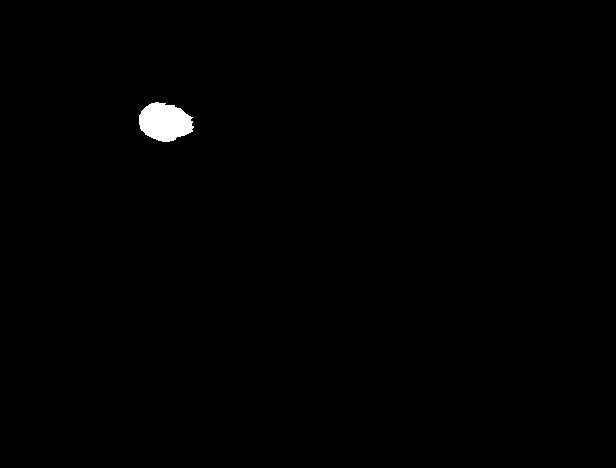

In [7]:
img = Image.open('/content/drive/MyDrive/Intermadiate_Machine_Learning/Final_project/training_set/benign/benign (54)_mask_1.png')
arr = np.array(img)


norm_mask(arr)

In [8]:
df.head()

,x_dim,y_dim,label,num_of_masks,path
0,562,471,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
1,323,473,benign,2,/content/drive/MyDrive/Intermadiate_Machine_Le...
2,683,585,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
3,810,695,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
4,769,582,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...


In [9]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1ayM-PdXWP3HcRy-uGPyTgvsHo1OTU6k8XFQdXpQQHFg#gid=0


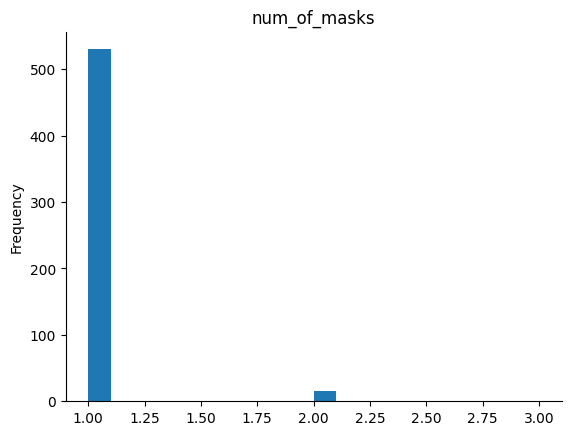

In [10]:
# @title num_of_masks

from matplotlib import pyplot as plt
df['num_of_masks'].plot(kind='hist', bins=20, title='num_of_masks')
plt.gca().spines[['top', 'right',]].set_visible(False)

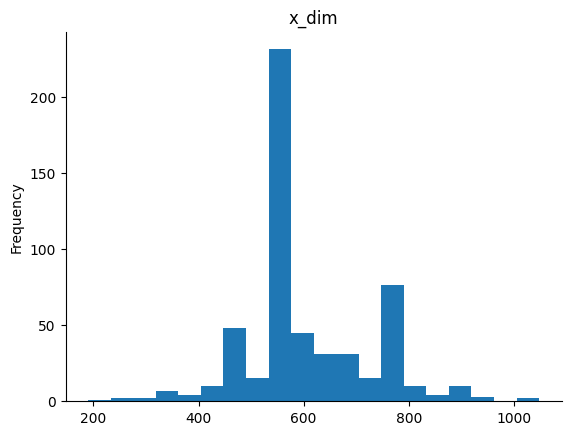

In [11]:
# @title x_dim

from matplotlib import pyplot as plt
df['x_dim'].plot(kind='hist', bins=20, title='x_dim')
plt.gca().spines[['top', 'right',]].set_visible(False)

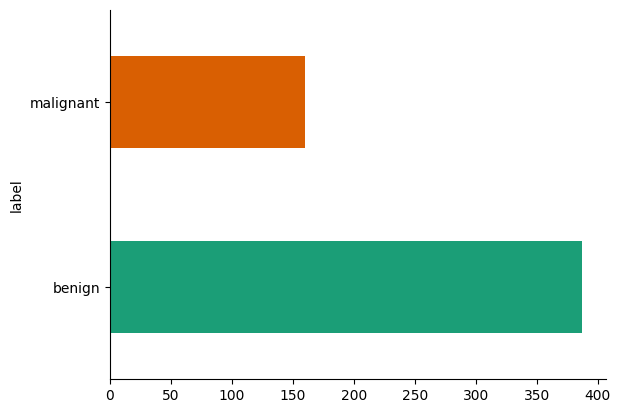

In [12]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
df.tail()

,x_dim,y_dim,label,num_of_masks,path
542,775,591,malignant,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
543,668,463,malignant,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
544,549,474,malignant,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
545,554,470,malignant,1,/content/drive/MyDrive/Intermadiate_Machine_Le...
546,561,499,malignant,1,/content/drive/MyDrive/Intermadiate_Machine_Le...


Check the Dataset Structure

In [14]:
import pandas as pd

# Check first few rows
print(df.head())

# Basic summary statistics of the dataset
print(df.describe())

# Check for missing data
print(df.isnull().sum())

# Check if there are any duplicates
print(df.duplicated().sum())


   x_dim  y_dim   label  num_of_masks  \
0    562    471  benign             1   
1    323    473  benign             2   
2    683    585  benign             1   
3    810    695  benign             1   
4    769    582  benign             1   

                                                path  
0  /content/drive/MyDrive/Intermadiate_Machine_Le...  
1  /content/drive/MyDrive/Intermadiate_Machine_Le...  
2  /content/drive/MyDrive/Intermadiate_Machine_Le...  
3  /content/drive/MyDrive/Intermadiate_Machine_Le...  
4  /content/drive/MyDrive/Intermadiate_Machine_Le...  
             x_dim       y_dim  num_of_masks
count   547.000000  547.000000    547.000000
mean    604.976234  492.124314      1.032907
std     120.395249   73.833487      0.188534
min     190.000000  324.000000      1.000000
25%     554.000000  463.000000      1.000000
50%     563.000000  471.000000      1.000000
75%     682.500000  570.000000      1.000000
max    1048.000000  719.000000      3.000000
x_dim           0


**Distribution of Benign vs Malignant Cases**

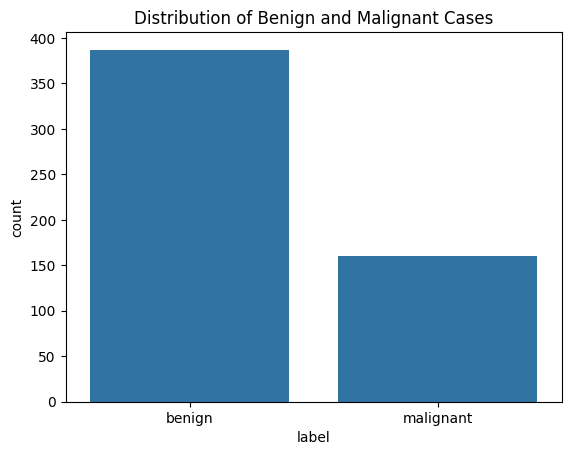

label
benign       70.749543
malignant    29.250457
Name: proportion, dtype: float64


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels (benign vs malignant)
sns.countplot(data=df, x='label')
plt.title("Distribution of Benign and Malignant Cases")
plt.show()

# Percentage of each label
label_counts = df['label'].value_counts(normalize=True) * 100
print(label_counts)


**Image Size Analysis**


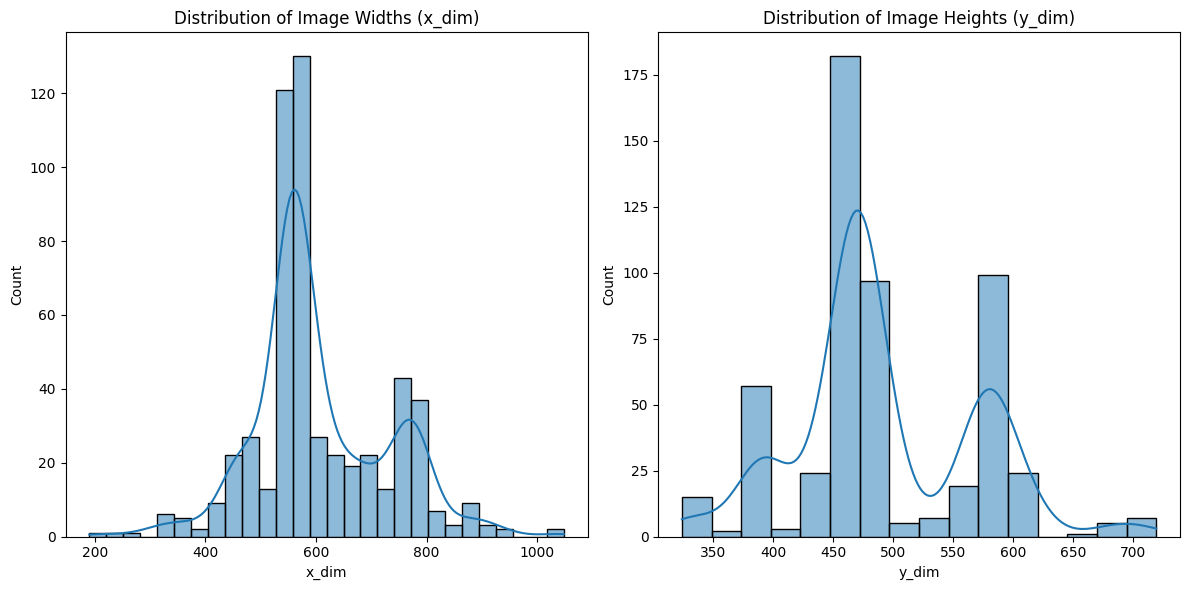

Min width: 190, Max width: 1048
Min height: 324, Max height: 719


In [16]:
# Plot the distribution of image dimensions
plt.figure(figsize=(12, 6))

# Plot width distribution
plt.subplot(1, 2, 1)
sns.histplot(df['x_dim'], kde=True)
plt.title('Distribution of Image Widths (x_dim)')

# Plot height distribution
plt.subplot(1, 2, 2)
sns.histplot(df['y_dim'], kde=True)
plt.title('Distribution of Image Heights (y_dim)')

plt.tight_layout()
plt.show()

# Check the minimum and maximum image dimensions
print(f"Min width: {df['x_dim'].min()}, Max width: {df['x_dim'].max()}")
print(f"Min height: {df['y_dim'].min()}, Max height: {df['y_dim'].max()}")


**Number of Masks per Study**

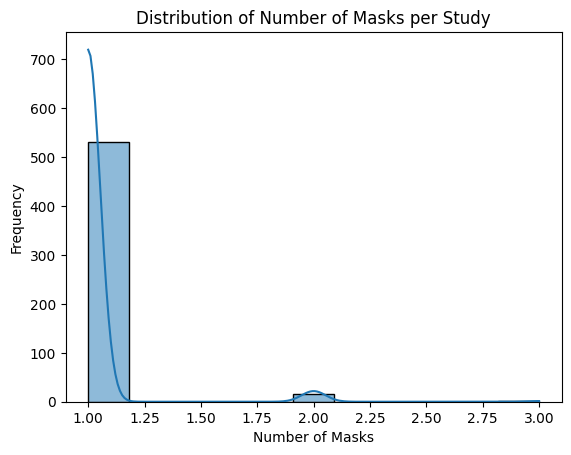

Min masks: 1, Max masks: 3


In [17]:
# Plot the distribution of number of masks per study
sns.histplot(df['num_of_masks'], kde=True)
plt.title('Distribution of Number of Masks per Study')
plt.xlabel('Number of Masks')
plt.ylabel('Frequency')
plt.show()

# Check the minimum and maximum number of masks
print(f"Min masks: {df['num_of_masks'].min()}, Max masks: {df['num_of_masks'].max()}")


**Image and Mask Visualizations**

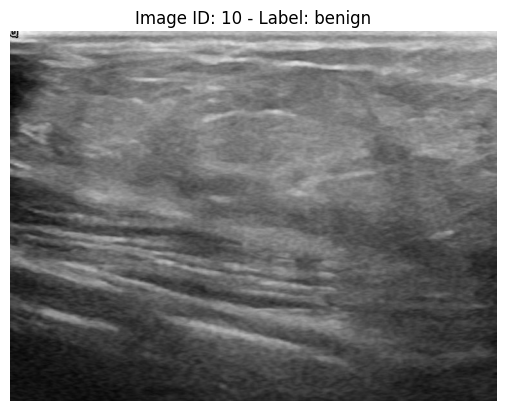

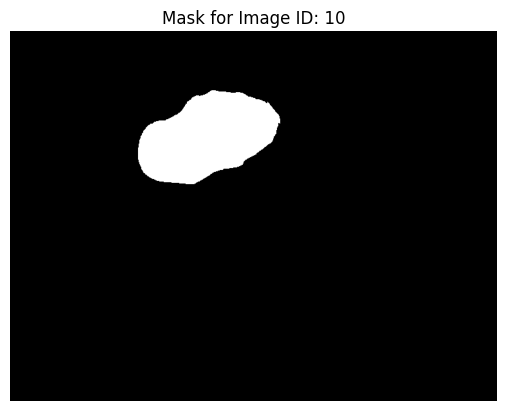

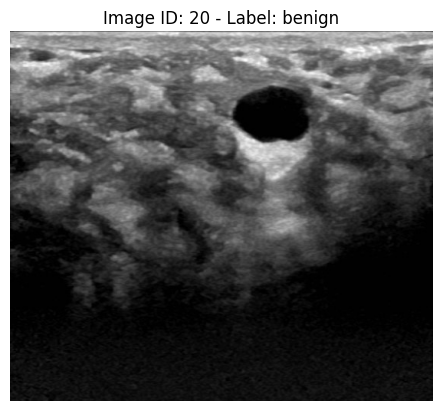

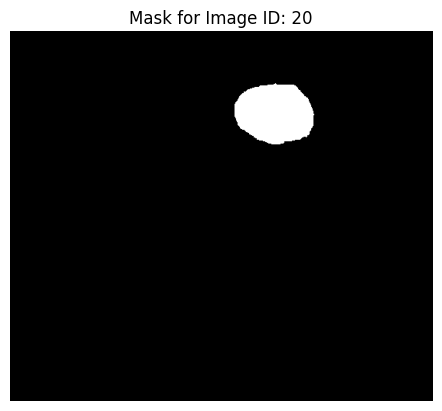

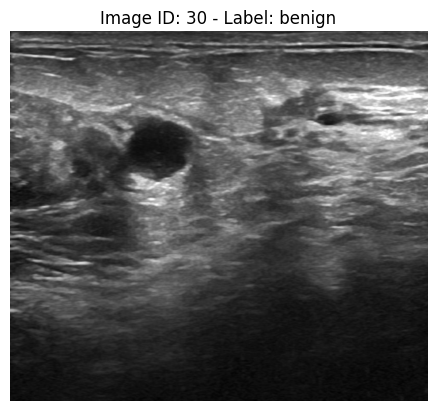

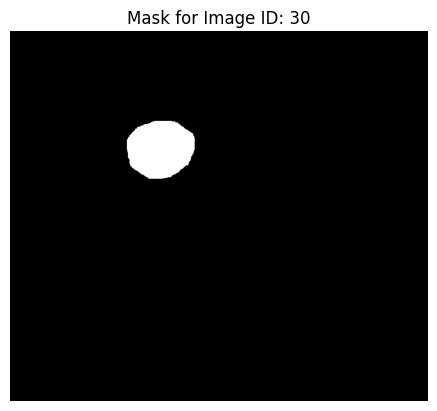

In [18]:
import numpy as np
from PIL import Image

def show_images_with_masks(df, index_list):
    """Visualizes a few random images and their masks."""
    for index in index_list:
        row = df.iloc[index]
        img = Image.open(row['path'])
        img = np.array(img)

        # Show the image
        plt.imshow(img)
        plt.title(f"Image ID: {row.name} - Label: {row['label']}")
        plt.axis('off')
        plt.show()

        # Now, show the masks
        study_id = row.name
        mask_paths = [f"{row['path'].split('.png')[0]}_mask.png"]
        for i in range(1, row['num_of_masks']):
            mask_paths.append(f"{row['path'].split('.png')[0]}_mask_{i}.png")

        for mask_path in mask_paths:
            if os.path.exists(mask_path):
                mask = np.array(Image.open(mask_path))
                plt.imshow(mask, cmap='gray')
                plt.title(f"Mask for Image ID: {study_id}")
                plt.axis('off')
                plt.show()

# Show a few images and their masks (replace with a few index values of your choice)
show_images_with_masks(df, [10, 20, 30])  # Example indices


**Check for Class Imbalance in Terms of Image Size**

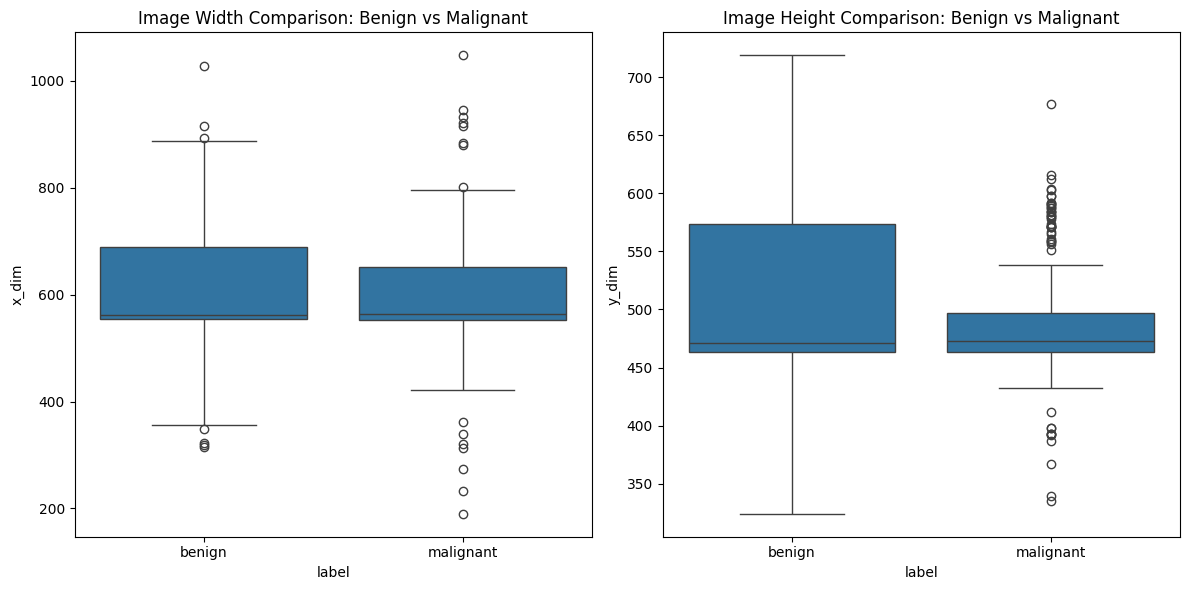

In [19]:
# Compare width and height distributions for benign vs malignant
plt.figure(figsize=(12, 6))

# Width comparison
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='label', y='x_dim')
plt.title('Image Width Comparison: Benign vs Malignant')

# Height comparison
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='label', y='y_dim')
plt.title('Image Height Comparison: Benign vs Malignant')

plt.tight_layout()
plt.show()


**Mask Distribution by Label (Benign vs Malignant)**

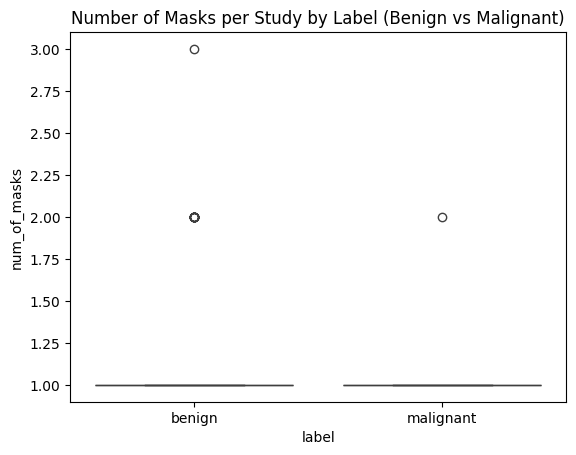

In [20]:
# Boxplot for number of masks by label
sns.boxplot(data=df, x='label', y='num_of_masks')
plt.title('Number of Masks per Study by Label (Benign vs Malignant)')
plt.show()


**Checking for Class Distribution in a Subset of Images**

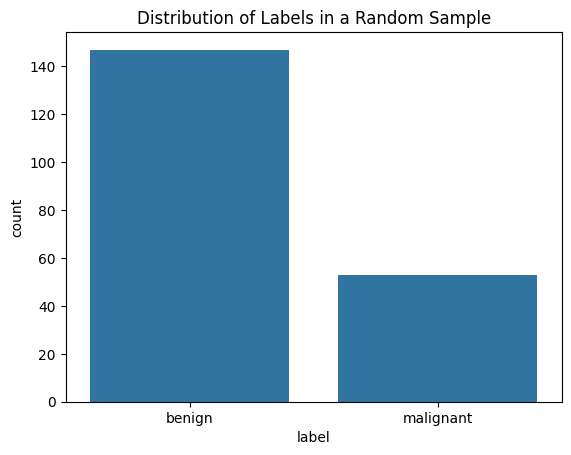

In [21]:
# Take a random sample of images
df_sample = df.sample(n=200, random_state=42)

# Plot the distribution of labels in the sample
sns.countplot(data=df_sample, x='label')
plt.title("Distribution of Labels in a Random Sample")
plt.show()


**Visualizing the Image Sizes Before and After Padding**

Original size (Height, Width): (575, 757, 3)
Padded size (Height, Width): (719, 1048, 3)


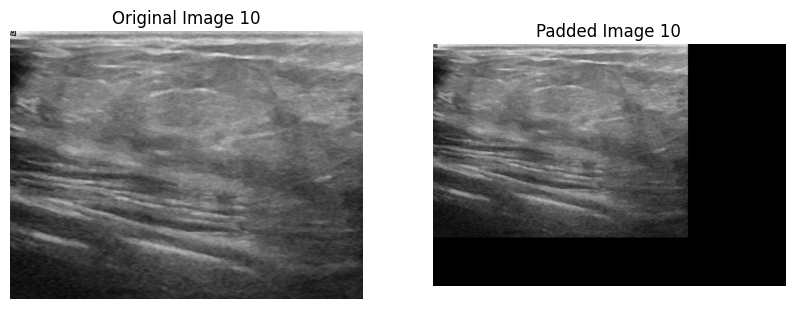

Original size (Height, Width): (483, 552, 3)
Padded size (Height, Width): (719, 1048, 3)


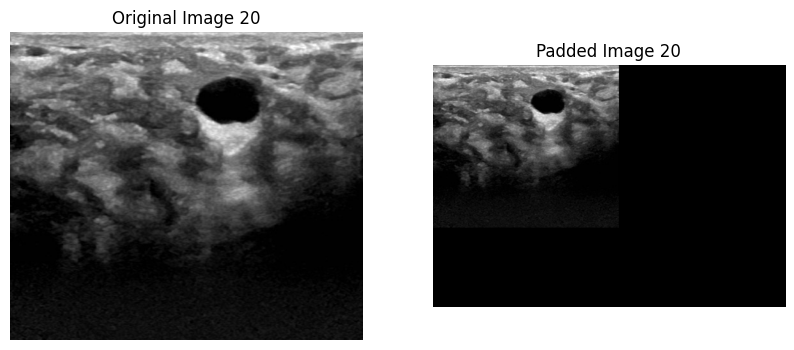

Original size (Height, Width): (716, 808, 3)
Padded size (Height, Width): (719, 1048, 3)


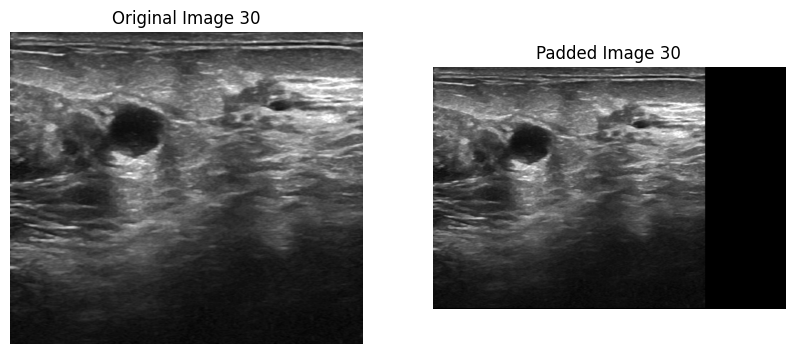

In [22]:
# Visualize original image size vs padded size
def visualize_padding(index):
    row = df.iloc[index]
    img = np.array(Image.open(row['path']))

    # Show original image size
    print(f"Original size (Height, Width): {img.shape}")

    padded_img = pad_image_to_max(img, (*max_shape, 3))

    # Show padded image size
    print(f"Padded size (Height, Width): {padded_img.shape}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image {row.name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(padded_img)
    plt.title(f"Padded Image {row.name}")
    plt.axis('off')

    plt.show()

# Visualize padding for a few random images
visualize_padding(10)
visualize_padding(20)
visualize_padding(30)


In [23]:
df_block.head()

,x_dim,y_dim,label,num_of_masks,path,padded_image,mask_tensor
0,562,471,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...,"[[[7, 7, 7], [2, 2, 2], [4, 4, 4], [7, 7, 7], ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,323,473,benign,2,/content/drive/MyDrive/Intermadiate_Machine_Le...,"[[[1, 1, 1], [0, 0, 0], [7, 7, 7], [182, 182, ...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,683,585,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...,"[[[15, 15, 15], [37, 37, 37], [210, 210, 210],...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,810,695,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...,"[[[50, 50, 50], [64, 64, 64], [77, 77, 77], [8...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,769,582,benign,1,/content/drive/MyDrive/Intermadiate_Machine_Le...,"[[[5, 5, 5], [0, 0, 0], [168, 168, 168], [189,...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


**Correlations**

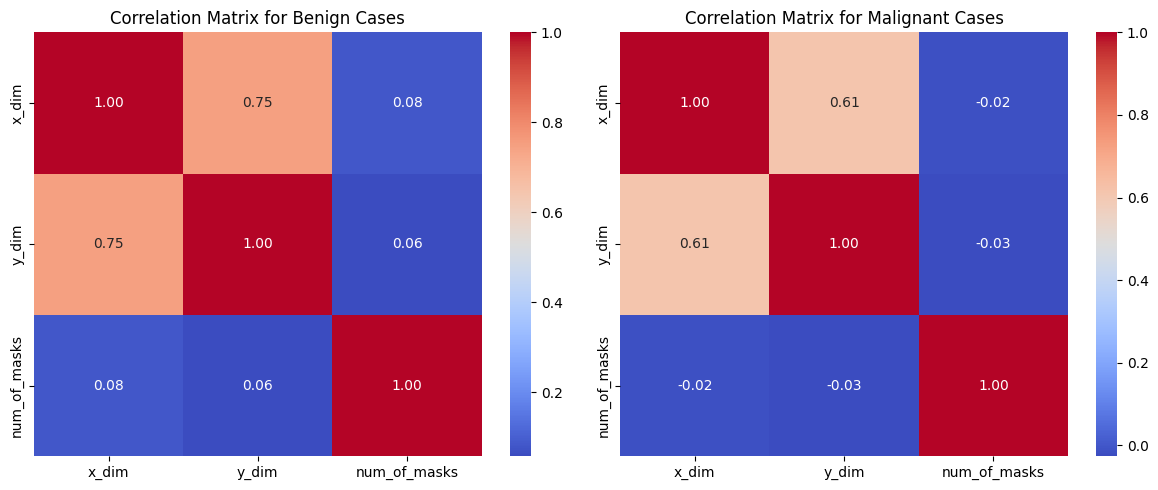

In [29]:

import seaborn as sns
import matplotlib.pyplot as plt


# Select numerical features and label
numerical_features = ['x_dim', 'y_dim', 'num_of_masks']
df_for_correlation = df[numerical_features + ['label']]

# Group data by label
benign_data = df_for_correlation[df_for_correlation['label'] == 'benign']
malignant_data = df_for_correlation[df_for_correlation['label'] == 'malignant']

# Calculate correlation matrices for each group
benign_corr = benign_data[numerical_features].corr()
malignant_corr = malignant_data[numerical_features].corr()

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(benign_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Benign Cases')

plt.subplot(1, 2, 2)
sns.heatmap(malignant_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Malignant Cases')

plt.tight_layout()
plt.show()
